In [1]:
%matplotlib widget

%load_ext autoreload
%autoreload 1

from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%aimport vis

pd.plotting.register_matplotlib_converters()

# make sure we have log dir
while not Path('log').is_dir():
    %cd ..

/home/peifeng/develop/cloudlab/automl


In [12]:
def load_jobs(slug, tag=''):
    # find log dir
    base_dir = Path('log')
    log_dir = base_dir / slug
    if not log_dir.is_dir():
        # try match
        for log_dir in base_dir.glob(f'*{slug}*'):
            if log_dir.is_dir():
                break
            raise ValueError(f'Log dir {log_dir} does not exist')
    
    # find file
    if tag:
        tag = tag + '-'
    csv_file = log_dir / f'{tag}jobs.csv'
    if not csv_file.is_file():
        # try glob
        for csv_file in log_dir.glob(f'*{tag}*jobs.csv'):
            if csv_file.is_file():
                break
            raise ValueError(f'CSV file {csv_file} does not exist')
    
    # load it
    print(f'Loading {csv_file}')
    total = pd.read_csv(str(csv_file))
    for col in ['StartTime', 'EndTime']:
        total[col] = pd.to_datetime(total[col])
    for col in ['Budget', 'Iter', 'JobId', 'Epoches', 'Node']:
        total[col] = pd.to_numeric(total[col])
    total['Duration'] = (total.EndTime - total.StartTime).astype('timedelta64[s]')
    return total

Two runs of Auto-PyTorch with 20 budgets and 2 iterations

In [24]:
df = pd.read_csv('log/2019-09-22T20:35:20/jobs.csv')
# df = pd.read_csv('log/2019-09-23T10:57:58/jobs.csv', sep='\t')
df['StartTime'] = pd.to_datetime(df['Start Time'])
df['EndTime'] = pd.to_datetime(df['End Time'])
df['Duration'] = df.EndTime - df.StartTime
df['Worker'] = pd.to_numeric(df.Worker)

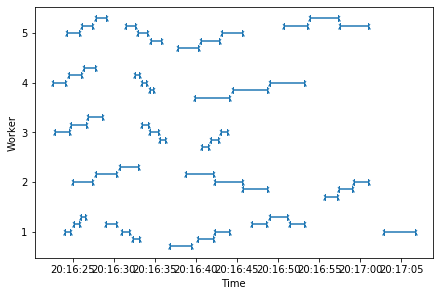

In [26]:
%matplotlib inline
_, ax = vis.subplots('Two runs of Auto-PyTorch with 20 budgets and 2 iterations')
ax = vis.job_timeline(df.Worker, df.StartTime, df.EndTime, ax=ax)

One run of hyperopt with 300 max eval

In [28]:
total = pd.DataFrame()
for node in range(1, 5):
    df = pd.read_csv(f'log/2019-09-30T10:04:29/hyper{node}.csv', sep='\t',
                     names=['StartTime', 'EndTime', 'Node'])
    total = total.append(df)
total = total.reset_index(drop=True)
total['Node'] = pd.to_numeric(total.Node)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
total = total.reset_index(drop=True)

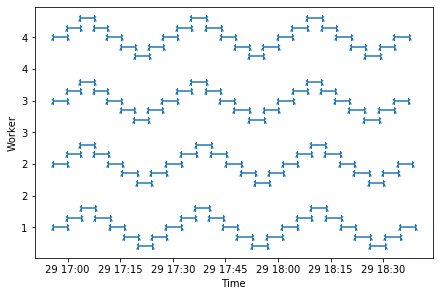

In [29]:
%matplotlib inline
_, ax = vis.subplots('One run of hyperopt with 300 max eval')
ax = vis.job_timeline(total.Node, total.StartTime, total.EndTime, ax=ax)

---

One run of Auto-PyTorch with 200 budget and 10 iterations.

It seems that the algorithm can finish earlier than max iterations

In [30]:
total = pd.DataFrame()
for node in range(1, 6):
    df = pd.read_csv(f'log/2019-09-30T10:04:29/node{node}.csv', sep='\t',
                     names=['Iter', 'Unknown', 'JobId', 'StartTime', 'EndTime'])
    df['Node'] = node
    total = total.append(df)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
total = total.reset_index(drop=True)

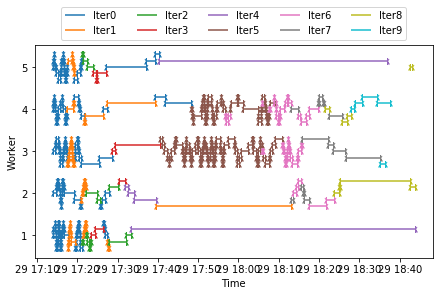

In [31]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 200 budget and 10 iterations')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5)

The job duration distribution of the same run

In [32]:
total['Duration'] = total.EndTime - total.StartTime
total['Duration'] = total.Duration.astype('timedelta64[s]')

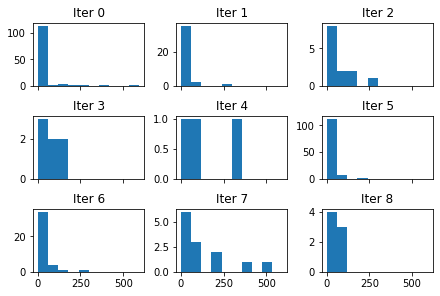

In [33]:
%matplotlib inline
_, axs = vis.subplots('Job duration distribution of the same run', nrows=3, ncols=3, sharex=True)
grouped = total.groupby('Iter')
bins = None
for ax, (it, grp) in zip(axs.flat, total.groupby('Iter')):
    _, bins, _ = ax.hist(grp.Duration, bins=bins)
    ax.set_title(f'Iter {it}')

10 workers

In [34]:
total = pd.DataFrame()
for node in range(1, 10):
    df = pd.read_csv(f'log/2019-10-07T11:29:19/worker{node}.log', sep='\t',
                     names=['StartTime', 'EndTime', 'Iter', 'JobId', 'Budget', 'Epoches'])
    df['Node'] = node
    total = total.append(df)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
for col in ['Budget', 'Iter', 'JobId', 'Epoches']:
    total[col] = pd.to_numeric(total[col])
total = total.reset_index(drop=True)

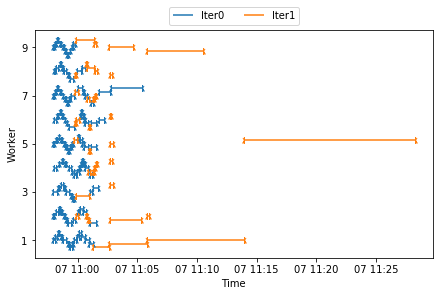

In [35]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 20 budget and 2 iterations with 10 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=2)

In [36]:
total['Duration'] = total.EndTime - total.StartTime
total['Duration'] = total.Duration.astype('timedelta64[s]')

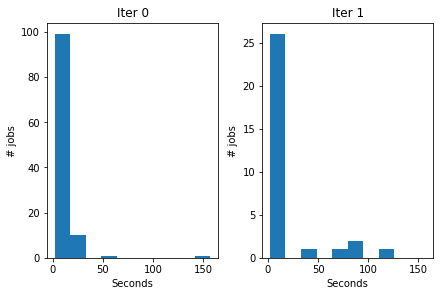

In [37]:
%matplotlib inline
_, axs = vis.subplots('Job duration distribution of the same run', nrows=1, ncols=2, sharex=True)
grouped = total.groupby('Iter')
bins = None
for ax, (it, grp) in zip(axs.flat, total.groupby('Iter')):
    _, bins, _ = ax.hist(grp.Duration, bins=bins)
    ax.set_title(f'Iter {it}')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('# jobs')

Text(0, 0.5, 'Second/Epoch')

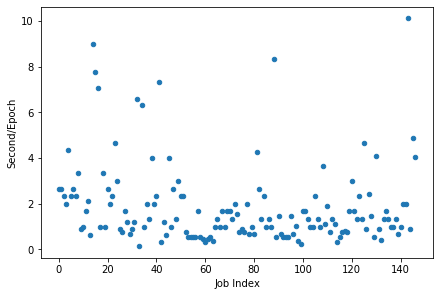

In [38]:
speed = total.Duration / total.Epoches
_, ax = vis.subplots('Job speed')
speed.reset_index().plot(x='index', y=0, ax=ax, kind='scatter')
ax.set_xlabel('Job Index')
ax.set_ylabel('Second/Epoch')

In [19]:
total = load_jobs('tentacled-seal')

Loading log/tentacled-seal/jobs.csv


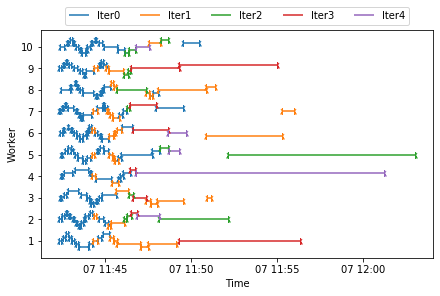

In [20]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 20 budget and 5 iterations with 10 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5)

In [13]:
total = load_jobs('pygmy', '7')

Loading log/pygmy-tapir/multiworker-num_worker-7-jobs.csv


In [22]:
_, ax = vis.subplots('One run of Auto-PyTorch with 100 budget and 5 iterations with 7 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …